Notebook to work out RL2 eval script to run on MASSIVE

In [1]:
import metaworld
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import warnings

# stop warnings
warnings.filterwarnings('ignore')

# from models import encoder, policy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
## get the model
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__25:10_21:13:08'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [3]:
from models.combined_actor_critic import ActorCritic

## RL2 agent
ac = ActorCritic(policy_net, encoder_net)

class rl2_agent:
    """
    Simple agent wrapper to run RL2 eval
    """
    def __init__(self, network):
        self.actor_critic = network

    def act(self, obs, latent, task = None, belief = None):
        return self.actor_critic.act(obs, latent, task, belief)
    
agent = rl2_agent(ac)

In [4]:
import metaworld
from environments.custom_env_utils import prepare_base_envs, prepare_parallel_envs

ML10 = metaworld.ML10()
# get task names
train_tasks = list(ML10.train_classes.keys())
test_tasks = list(ML10.test_classes.keys())


# training_envs = prepare_base_envs(train_tasks, benchmark=ML10)
# par_training_envs = prepare_parallel_envs(training_envs, 500, 10, device)

In [30]:
training_envs = prepare_base_envs(train_tasks, benchmark=ML10, task_set='train')
par_training_envs = prepare_parallel_envs(training_envs, 500, 10, device)

In [69]:
def eval_rl2(agent, tasks, benchmark, task_set, num_eval):
    raw_envs = prepare_base_envs(tasks, benchmark, task_set)
    envs = prepare_parallel_envs(
        raw_envs,
        500, 
        num_eval,
        device
    )
    results = {
        task:{
            'reward_mean': 0,
            'reward_std': 0,
            'successes' :0
        } for task in tasks
    }
    while envs.get_env_attr('cur_step') < envs.get_env_attr('steps_limit'):

        obs = envs.reset() # we reset all at once as metaworld is time limited
        current_task = tasks[envs.get_env_attr('cur_seq_idx')]
        episode_reward = []
        successes = []
        done = [False for _ in range(num_eval)]

        ## TODO: determine how frequently to get prior - do at start of each episode for now
        with torch.no_grad():
            _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_eval)
            latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)


        while not all(done):
            with torch.no_grad():
                _, action = agent.act(obs, latent, None, None)
            next_obs, reward, done, info = envs.step(action)
            assert all(done) == any(done), "Metaworld envs should all end simultaneously"

            obs = next_obs

            ## combine all rewards
            episode_reward.append(reward)
            # if we succeed at all then the task is successful
            successes.append(torch.tensor([i['success'] for i in info]))

            with torch.no_grad():
                _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
                latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]

        ## log the results here
        rewards_to_log = torch.stack(episode_reward).squeeze().cpu()
        results[current_task]['reward_mean'] = rewards_to_log.mean().numpy()
        results[current_task]['reward_std'] = rewards_to_log.std().numpy()
        results[current_task]['successes'] = (torch.stack(successes).max(0)[0].sum() / num_eval).numpy()

    cleaned_results = clean_results(results)
    return cleaned_results

    # cleaned_results.to_csv(logging_path)

def clean_results(results_dict):
    df = pd.DataFrame(results_dict).T.reset_index().rename(columns={'index':'task'})
    df.loc[:,'task'] = df.loc[:,'task'].astype('category')
    df.loc[:,'reward_mean'] = df.loc[:,'reward_mean'].astype('float')
    df.loc[:,'reward_std'] = df.loc[:,'reward_std'].astype('float')
    df.loc[:,'successes'] = df.loc[:,'successes'].astype('float')
    return df
    

In [64]:
test_processes = 32 # samples per task to eval
raw_test_envs = prepare_base_envs(test_tasks, benchmark=ML10, task_set='test')
test_envs = prepare_parallel_envs(
    raw_test_envs,
    500,
    test_processes,
    device
)

res = {task: {'reward_mean':[], 'reward_std':[], 'successes':[]} for task in test_tasks}
while test_envs.get_env_attr('cur_step') < test_envs.get_env_attr('steps_limit'):

        obs = test_envs.reset() # we reset all at once as metaworld is time limited
        current_task = test_tasks[test_envs.get_env_attr('cur_seq_idx')] ## TODO: make test_tasks a parameter
        episode_reward = []
        successes = []
        done = [False for _ in range(test_processes)]

        ## TODO: determine how frequently to get prior - do at start of each episode for now
        with torch.no_grad():
            _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(test_processes)
            latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)


        while not all(done):
            with torch.no_grad():
                _, action = agent.act(obs, latent, None, None)
            next_obs, reward, done, info = test_envs.step(action)
            assert all(done) == any(done), "Metaworld envs should all end simultaneously"

            obs = next_obs

            ## combine all rewards
            episode_reward.append(reward)
            # if we succeed at all then the task is successful
            successes.append(torch.tensor([i['success'] for i in info]))

            with torch.no_grad():
                _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
                latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]

        ## log the results here
        rewards_to_log = torch.stack(episode_reward).squeeze().cpu()
        res[current_task]['reward_mean'] = rewards_to_log.mean().numpy()
        res[current_task]['reward_std'] = rewards_to_log.std().numpy()
        res[current_task]['successes'] = (torch.stack(successes).max(0)[0].sum() / test_processes).numpy()

# # tidy up results
# for task in test_tasks:
#      res[task]['rewards'] = res[task]['rewards'].squeeze()




In [65]:
df = pd.DataFrame(res).T.reset_index().rename(columns={'index':'task'})
df.loc[:,'task'] = df.loc[:,'task'].astype('category')
df.loc[:,'reward_mean'] = df.loc[:,'reward_mean'].astype('float')
df.loc[:,'reward_std'] = df.loc[:,'reward_std'].astype('float')
df.loc[:,'successes'] = df.loc[:,'successes'].astype('float')

In [73]:
results = eval_rl2(agent, train_tasks, ML10, 'train', 32)
results

,task,reward_mean,reward_std,successes
0,reach-v2,1.667807,1.116329,0.0
1,push-v2,0.009024,0.010942,0.0
2,pick-place-v2,0.00419,0.003915,0.0
3,door-open-v2,0.778715,0.198087,0.0
4,drawer-close-v2,6.423393,4.784329,0.84375
5,button-press-topdown-v2,0.979794,0.175235,0.0
6,peg-insert-side-v2,0.007734,0.003592,0.0
7,window-open-v2,0.710183,0.632933,0.1875
8,sweep-v2,0.031412,0.027398,0.0
9,basketball-v2,0.00508,0.007888,0.0


<Axes: xlabel='reward_std', ylabel='reward_mean'>

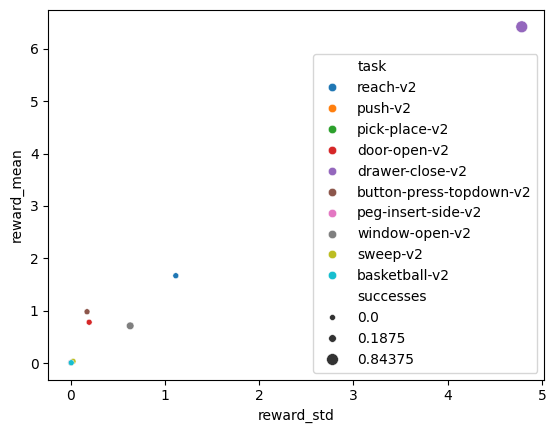

In [77]:
import seaborn as sns

sns.scatterplot(
    data = results,
    x = 'reward_std',
    y = 'reward_mean',
    hue='task',
    size = 'successes'
)

<Axes: xlabel='task', ylabel='successes'>

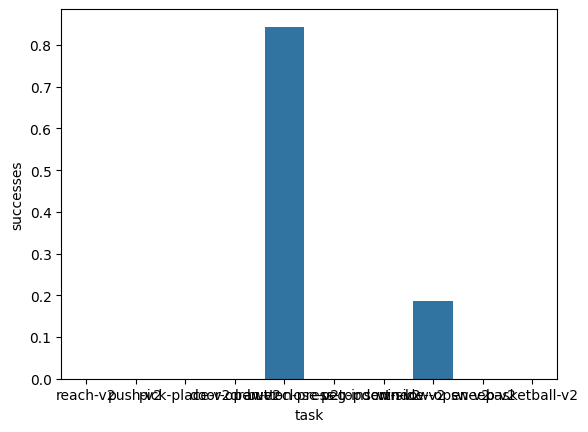

In [75]:
sns.barplot(
    data = results,
    x = 'task',
    y = 'successes'
)

In [ ]:
def evaluate(raw_test_envs, test_processes = 10):
    start_time = time.time() # use this in logger?
    # current_task_name = self.env_id_to_name[current_task + 1]
    
    ## num runs given by test_processes
    test_envs = prepare_parallel_envs(
        raw_test_envs, 
        500,
        test_processes, 
        device
    )

    # record outputs
    # task_rewards = {
    #     task_name: [] for task_name in self.task_names
    # }

    # task_successes = {
    #     task_name: [] for task_name in self.task_names
    # }

    while test_envs.get_env_attr('cur_step') < test_envs.get_env_attr('steps_limit'):

        obs = test_envs.reset() # we reset all at once as metaworld is time limited
        episode_reward = []
        successes = []
        done = [False for _ in range(test_processes)]

        ## TODO: determine how frequently to get prior - do at start of each episode for now
        with torch.no_grad():
            _, latent_mean, latent_logvar, hidden_state = self.agent.actor_critic.encoder.prior(test_processes)
            latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)


        while not all(done):
            with torch.no_grad():
                _, action = self.agent.act(obs, latent, None, None)
            next_obs, reward, done, info = test_envs.step(action)
            assert all(done) == any(done), "Metaworld envs should all end simultaneously"

            obs = next_obs

            ## combine all rewards
            episode_reward.append(reward)
            # if we succeed at all then the task is successful
            successes.append(torch.tensor([i['success'] for i in info]))

            with torch.no_grad():
                _, latent_mean, latent_logvar, hidden_state = self.agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
                latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]

        ## log the results here
        task_rewards[self.env_id_to_name[test_envs.get_env_attr('cur_seq_idx')]] = torch.stack(episode_reward).cpu()
        task_successes[self.env_id_to_name[test_envs.get_env_attr('cur_seq_idx')]] = torch.stack(successes).max(0)[0].sum() #/ test_processes

    end_time = time.time()
    self.logger.add_tensorboard('current_task', current_task, eps)

    #log rewards, successes to tensorboard
    ## TODO: is there a neater way? e.g. log each of these under the same board
    self.logger.add_multiple_tensorboard('mean_task_rewards', {name: torch.mean(rewards) for name, rewards in task_rewards.items()}, eps)
    self.logger.add_multiple_tensorboard('task_successes', task_successes, eps)

    # log reward quantiles, successes to csv
    # ['training_task', 'evaluation_task', 'successes', 'result_mean', *['q_' + str(q) for q in self.logging_quantiles], 'episode']
    for task in self.task_names:
        reward_quantiles = torch.quantile(
            task_rewards[task],
            torch.tensor(self.quantiles)
        ).numpy().tolist()

        to_write = (
            current_task_name,
            task,
            task_successes[task].numpy(),
            test_processes, # record number of eval tasks per env
            task_rewards[task].mean().numpy(),
            *reward_quantiles,
            eps
        )
        self.logger.add_csv(to_write)
    
    print(f"eval completed in {end_time - start_time}")
    test_envs.close()